# 0. Accelerator

In [ ]:
# This will need to run once per machine to make sure everything is installed
# If you are working in Google Colab make sure you change the runtime type to have 'Hardware accelerator' as GPU
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 17.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [ ]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

# 1. Load Dataset

In [ ]:
import csv
import random

# Path to your CSV file
input_csv = '/content/Compiled Data.csv'
output_csv = '/content/Compiled Data - Shuffled.csv'

# Read the CSV file
with open(input_csv, mode='r', newline='') as file:
    reader = csv.reader(file)
    header = next(reader)  # Extract the first row (header)
    rows = list(reader)    # Extract remaining rows

# Shuffle the rows except the header
random.shuffle(rows)

# Write the shuffled data back to a new CSV file
with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)  # Write the header
    writer.writerows(rows)   # Write the shuffled rows

In [ ]:
import csv
import json
from sklearn.model_selection import train_test_split

# Replace with the actual path to your shuffled CSV file
shuffled_csv_path = '/content/Compiled Data - Shuffled.csv'

# Function to convert CSV data to JSONL format
def csv_to_jsonl(csv_path):
    data_jsonl = []
    with open(csv_path, mode='r', newline='', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            data_jsonl.append(json.dumps(row))
    return data_jsonl

# Load CSV data and convert to JSONL
data_jsonl = csv_to_jsonl(shuffled_csv_path)

# Splitting the data into training, validation, and testing datasets
# Let's use a 80-10-10 split as an example
train_data, temp_data = train_test_split(data_jsonl, test_size=0.2, random_state=42)
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Function to save datasets to JSONL files
def save_dataset_jsonl(dataset, filename):
    with open(filename, mode='w', encoding='utf-8') as file:
        for item in dataset:
            file.write(item + '\n')

# Save the datasets to files
save_dataset_jsonl(train_data, 'train_dataset.jsonl')
save_dataset_jsonl(validation_data, 'validation_dataset.jsonl')
save_dataset_jsonl(test_data, 'test_dataset.jsonl')


In [ ]:
from datasets import load_dataset

# Loading the training dataset
train_dataset = load_dataset('json', data_files='train_dataset.jsonl', split='train')

# Loading the validation dataset
val_dataset = load_dataset('json', data_files='validation_dataset.jsonl', split='train')

# Loading the test dataset
test_dataset = load_dataset('json', data_files='test_dataset.jsonl', split='train')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
def format_data_for_training(row):
    # Extract the paragraph and feedback from the row
    paragraph = row['\ufeffParagraph']
    feedback = row['Feedback']

    # Format the data into a dictionary with 'input_text' and 'feedback'
    formatted_example = {
        'input_text': paragraph.strip(),  # Remove any leading/trailing whitespace
        'feedback': feedback.strip()      # Remove any leading/trailing whitespace
    }
    return formatted_example

In [ ]:
# Apply formatting function to the datasets
train_dataset = train_dataset.map(format_data_for_training)
val_dataset = val_dataset.map(format_data_for_training)
test_dataset = test_dataset.map(format_data_for_training)


Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/11 [00:00<?, ? examples/s]

# 2. Load Base Model

## Login to Hugging Face

In [ ]:
!pip install --upgrade huggingface_hub

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


## Base Model

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "meta-llama/Llama-2-7b-hf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

# 3. Tokennization

tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/11 [00:00<?, ? examples/s]

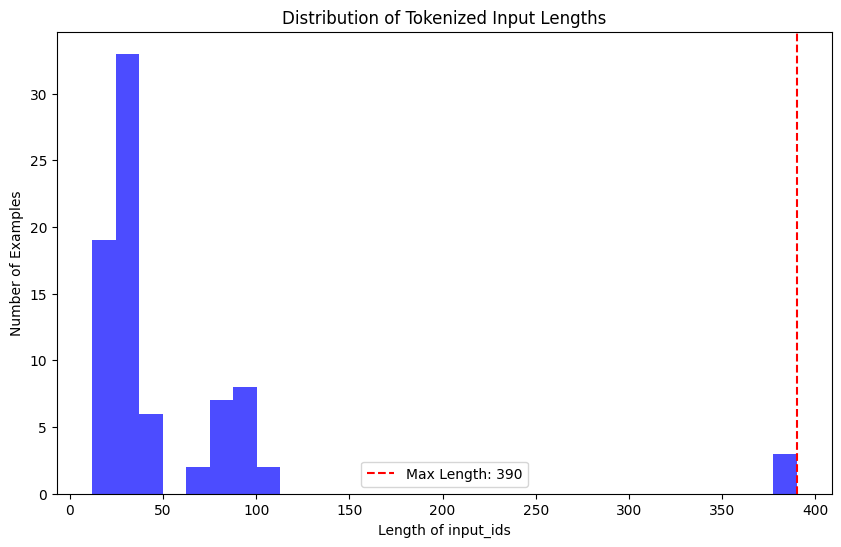

In [ ]:
from transformers import AutoTokenizer
from datasets import load_dataset
import matplotlib.pyplot as plt

# Initialize the tokenizer
tokenizer_model_id = 'meta-llama/Llama-2-7b-hf'
tokenizer = AutoTokenizer.from_pretrained(tokenizer_model_id, use_fast=True)

# Check and set the tokenizer's padding token
if tokenizer.pad_token is None:
    if tokenizer.eos_token:
        tokenizer.pad_token = tokenizer.eos_token
    else:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        tokenizer.pad_token_id = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)

# Correct the input column name by removing the BOM
input_column = '\ufeffParagraph'  # Use the column name as it appears, including the BOM

# Function to calculate the length of the input_ids for each example
def calculate_length(example):
    tokens = tokenizer.encode(example[input_column], add_special_tokens=True)
    return len(tokens)

# Determine the max_length based on the dataset
lengths = [calculate_length(example) for example in train_dataset]
max_length = min(max(lengths), tokenizer.model_max_length)

# Function to tokenize an entry
def tokenize_entry(example):
    return tokenizer(
        example[input_column],
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )

# Apply tokenization to the datasets
tokenized_train_dataset = train_dataset.map(tokenize_entry, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_entry, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_entry, batched=True)

# Plot the distribution of lengths
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=30, alpha=0.7, color='blue')
plt.xlabel('Length of input_ids')
plt.ylabel('Number of Examples')
plt.title('Distribution of Tokenized Input Lengths')
plt.axvline(x=max_length, color='red', linestyle='--', label=f'Max Length: {max_length}')
plt.legend()
plt.show()


# 5. Set Up Lora

In [ ]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
print(model)


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRM

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

# Apply the accelerator. You can comment this out to remove the accelerator.
model = accelerator.prepare_model(model)

trainable params: 81108992 || all params: 3581521920 || trainable%: 2.264651559077991


In [ ]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Linear4bit(

In [ ]:
!pip install wandb

import wandb, os
wandb.login()

wandb_project = "feedback-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.7 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


#6. Model Training

In [ ]:
!pip install torch

In [ ]:
import torch

if torch.cuda.device_count() > 1:  # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True


In [ ]:
import transformers
from datetime import datetime

# Configuration
project = "feedback-finetune"
base_model_name = "llama2-7b"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

# Ensure the tokenizer's pad token is set
tokenizer.pad_token = tokenizer.eos_token

# Data collator
data_collator = transformers.DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False
)

# Trainer initialization
trainer = transformers.Trainer(
    model=model,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=3,  # Based on the small dataset, 3 epochs may suffice
        per_device_train_batch_size=4,  # Optimized based on GPU memory
        per_device_eval_batch_size=8,   # Usually can be double the train batch size if memory allows
        warmup_steps=20,  # Less warmup needed for smaller datasets
        max_steps=100,  # Lower this if you want quicker iterations
        learning_rate=2e-5,  # A common starting point for fine-tuning
        weight_decay=0.01,  # Helps prevent overfitting on small datasets
        logging_dir="./logs",
        logging_steps=25,  # Log every 25 steps
        save_steps=5,  # Save checkpoint less frequently to save time
        evaluation_strategy="steps",
        eval_steps=5,  # Evaluate every 25 steps
        load_best_model_at_end=True,  # Load the best model at the end based on evaluation
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to="wandb",  # Set to "none" if not using Weights & Biases
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}",
        skip_memory_metrics=False,  # Set to True to save some logging memory
    ),
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    data_collator=data_collator,
)

# Train the model
trainer.train()

# After training is complete, you may want to save the model and the tokenizer
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Optionally, evaluate the model on the test set after training
test_results = trainer.evaluate(tokenized_test_dataset)
print(f"Test Loss: {test_results['eval_loss']:.4f}")


wandb: Currently logged in as: yfranci. Use `wandb login --relogin` to force relogin


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
5,No log,1.826418
10,No log,1.804613
15,No log,1.765888
20,No log,1.714992
25,2.159500,1.676667
30,2.159500,1.646701
35,2.159500,1.624172
40,2.159500,1.600060
45,2.159500,1.577182
50,1.774200,1.550850


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in

Test Loss: 1.5055


# 7. Test Models and Compare

## Load the Base Model (LLAMA2 7b)

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "meta-llama/Llama-2-7b-hf"
bnb_config = BitsAndBytesConfig(...)  # Configure as needed

model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)


ValueError: ignored

## Evalution of Base Model

In [ ]:
eval_prompt = """
Task: Provide a detailed evaluation of the student's essay. The essay topic is 'Do you think dogs or cats make better pets?' Your feedback should be specific and constructive, identifying both strengths and areas for improvement.

Essay:
'This is why I like dogs better than cats. I think dogs are really playful. They can also be strong to pull you or something. They come in different sizes, like a Great Dane or a Wiener dog, and in various colors. Some are mixed breeds, while others are purebred. Best of all, dogs are cute and cuddly. That's why I like dogs a lot better than cats.'

## FEEDBACK:
"""

In [ ]:
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=300, pad_token_id=2)[0], skip_special_tokens=True))

NameError: ignored

In [ ]:
eval_prompt = """
Task: Assess the student's essay on Act One of 'A Raisin in the Sun' by Lorraine Hansberry. The focus should be on their identification and analysis of the family conflict between Walter and Beneatha, relating it to their own experiences. Provide detailed, constructive feedback, highlighting strengths and offering suggestions for enhancement.

Essay:
'In the play, A Raisin in the Sun, by Lorraine Hansberry, I can most relate to the conflict between Walter and Beneatha. Walter and Beneatha are brother and sister; they do not get along very well, and both of them are very outspoken people.

Walter has at least one sibling that we know of, and that is Beneatha. I have seven siblings and all of them just happen to be boys. So, even though I cannot relate to having a sister, I can relate to the conflicts that exist between all siblings, regardless of sex.

They do not get along very well because they are brother and sister. If they were neighbors, and they did not get along very well with each other, they at least would not have to make any effort to change that because they would not be living together. However, Walter and Beneatha do live together, and have done so for 20 years. So obviously, since they are forced to live together, some tension does exist. I did not get along well with any of my brothers until they all moved out.

Walter and Beneatha are very outspoken about how they feel about each other. Walter makes it clear that Beneatha’s dream of becoming a doctor is not a realistic dream and that she should become a nurse. Beneatha talks about Walter’s friends. And it just goes back and forth. My brothers and I to this day, still make comments like that to each other.

The conflicts occur between Walter and Beneatha because they are brother and sister. It is a given in life that conflicts will exist between brothers and sisters. In, A Raisin in the Sun, as well as in my life, such conflicts exist.'

## FEEDBACK:
"""


In [ ]:
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=300, pad_token_id=2)[0], skip_special_tokens=True))

## Load the Finetuned Model

In [ ]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "/content/llama2-7b-feedback-finetune/checkpoint-100")


## Prepare the Prompts and Essays for evaluation

### Prepare the Input for Each Prompt

In [ ]:
prompt1 = """
Task: Provide a detailed evaluation of the student's essay. The essay topic is 'Do you think dogs or cats make better pets?' Your feedback should be specific and constructive, identifying both strengths and areas for improvement.

Essay:
'This is why I like dogs better than cats. I think dogs are really playful. They can also be strong to pull you or something. They come in different sizes, like a Great Dane or a Wiener dog, and in various colors. Some are mixed breeds, while others are purebred. Best of all, dogs are cute and cuddly. That's why I like dogs a lot better than cats.'

## FEEDBACK:
"""

model_input1 = tokenizer(prompt1, return_tensors="pt").to("cuda")

prompt2 ="""
Task: Assess the student's essay on Act One of 'A Raisin in the Sun' by Lorraine Hansberry. The focus should be on their identification and analysis of the family conflict between Walter and Beneatha, relating it to their own experiences. Provide detailed, constructive feedback, highlighting strengths and offering suggestions for enhancement.

Essay:
'In the play, A Raisin in the Sun, by Lorraine Hansberry, I can most relate to the conflict between Walter and Beneatha. Walter and Beneatha are brother and sister; they do not get along very well, and both of them are very outspoken people.

Walter has at least one sibling that we know of, and that is Beneatha. I have seven siblings and all of them just happen to be boys. So, even though I cannot relate to having a sister, I can relate to the conflicts that exist between all siblings, regardless of sex.

They do not get along very well because they are brother and sister. If they were neighbors, and they did not get along very well with each other, they at least would not have to make any effort to change that because they would not be living together. However, Walter and Beneatha do live together, and have done so for 20 years. So obviously, since they are forced to live together, some tension does exist. I did not get along well with any of my brothers until they all moved out.

Walter and Beneatha are very outspoken about how they feel about each other. Walter makes it clear that Beneatha’s dream of becoming a doctor is not a realistic dream and that she should become a nurse. Beneatha talks about Walter’s friends. And it just goes back and forth. My brothers and I to this day, still make comments like that to each other.

The conflicts occur between Walter and Beneatha because they are brother and sister. It is a given in life that conflicts will exist between brothers and sisters. In, A Raisin in the Sun, as well as in my life, such conflicts exist.'

## FEEDBACK:
"""

model_input2 = tokenizer(prompt2, return_tensors="pt").to("cuda")


### Run Inference of Both Models

In [ ]:
# For Essay 1
print ("Finetuned Model:")
ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input1, max_new_tokens=300)[0], skip_special_tokens=True))


In [ ]:
# For Essay 2
print ("Finetuned Model:")
ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input2, max_new_tokens=300)[0], skip_special_tokens=True))